# PS6
## Li Ruixue

## 1. Decision Trees
#### Split the data into a training set (70%) and a test set (30%). Be sure to set your seed prior to this part of your code to guarantee reproducibility of results. Use recursive binary splitting to fit a decision tree to the train-ing data, with biden as the response variable and the other variables as predictors. Plot the tree and interpret the results. What is the test MSE?

In [60]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

biden_df = pd.read_csv('../../ProblemSets/PS6/biden.csv', sep=',')
biden_df.head()

,biden,female,age,educ,dem,rep
0,90,0,19,12,1,0
1,70,1,51,14,1,0
2,60,0,27,14,0,0
3,50,1,43,14,1,0
4,60,1,38,14,0,1


In [61]:
y = biden_df['biden'].values
X = biden_df[['female', 'age', 'dem', 'rep', 'educ']].values

In [69]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3,
                                                    random_state=25)

biden_tree = DecisionTreeRegressor(max_depth = 10, min_samples_leaf=5)
biden_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

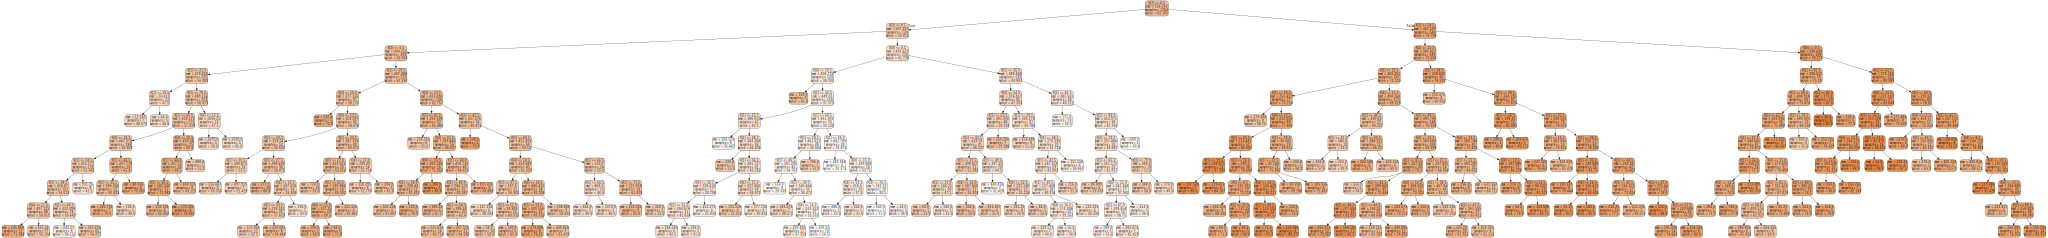

In [70]:
from sklearn.tree import export_graphviz
import graphviz

biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    rounded=True,
    filled=True,
)

graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

In [71]:
y_pred = biden_tree.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
print('MSE=', MSE)

MSE= 470.59816532924947


X[0]:female, X[1]:age, X[2]:dem, X[3]:rep, X[4]:educ  

The first split happens with X[2]:dem at 0.5. If X[2] <= 0.5 is false, meaning that the Democrat half of the samples, then the opinion of Biden is better, which is expected since Biden is a Democrat.   

Then for those that are not democrat, the next factor that split their opinion of Biden is whether they are republicans or not. Those who are not republicans have a higher opinion. For those who are democrats, age divides their opinion. Those who are older tend to like Biden more. Then both groups can be further split for multiple times. 

The test MSE is 470.6

#### (b) Leave the control options for tree() at their default values. Now fit another tree to the training data with the following control options: tree(control = tree.control(nobs = # number of rows in the training set, mindev = 0)) Use cross-validation to determine the optimal level of tree complexity, plot the optimal tree, and interpret the results. Does pruning the tree improve the test MSE?

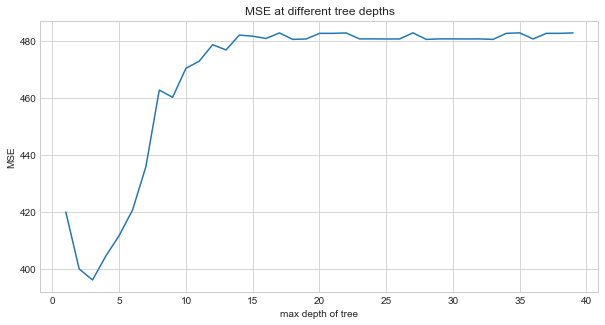

In [89]:
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3,
                                                    random_state=25)

MSEs = []
depths = []

for i in range(1, 40):
    
    biden_tree = DecisionTreeRegressor(max_depth=i, min_samples_leaf=5)
    biden_tree.fit(X_train, y_train)

    y_pred = biden_tree.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    MSEs.append(MSE)
    depths.append(i)

#print(depths, MSEs)
plt.figure(figsize = (10, 5))
plt.plot(depths, MSEs)
plt.xlabel('max depth of tree')
plt.ylabel('MSE')
plt.title('MSE at different tree depths')
plt.show()

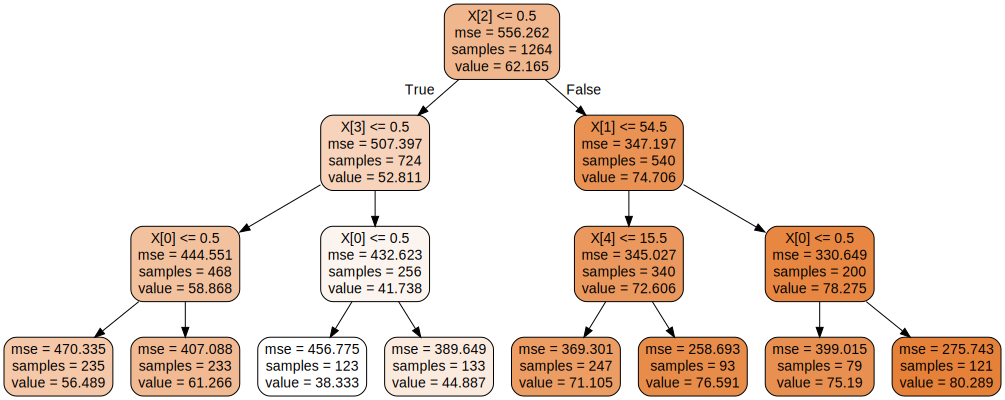

In [72]:
biden_tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=5)
biden_tree.fit(X_train, y_train)
biden_tree_viz = export_graphviz(
    biden_tree,
    out_file=None,
    rounded=True,
    filled=True,
)
y_pred = biden_tree.predict(X_test)
MSE = mean_squared_error(y_test, y_pred)
graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree_viz')
graph

By pruning the tree to max depth 3, we obtain a much smaller tree that has clearer interpretation and much smaller MSE, which means that the predicting power improved because of less overfitting problem. The first 3 layers and the interpretation are the same as part (a).

#### (c) Use the bagging approach to estimate a tree to create a model for predicting biden. What test MSE do you obtain? Obtain variable importance measures and interpret the results.

In [75]:
from sklearn.ensemble import BaggingRegressor

biden_tree_bagging = BaggingRegressor(DecisionTreeRegressor(),
                                      n_estimators=100,
                                      max_samples=100, bootstrap=True,
                                      oob_score=True, random_state=25)
biden_tree_bagging.fit(X, y)

biden_tree_bagging.score(X, y)
y_pred_bagging = biden_tree_bagging.oob_prediction_
MSE_bagging = mean_squared_error(y, y_pred_bagging)
print('MSE=', MSE_bagging)

MSE= 405.2780991902757


In [93]:
importances = np.mean([tree.feature_importances_ for tree in biden_tree_bagging.estimators_],
             axis=0)
print(importances)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

features = ['female', 'age', 'dem', 'rep', 'educ']
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[indices[f]], ": ",str(importances[indices[f]]))


[0.05796187 0.4398161  0.18411913 0.11216499 0.20593791]
Feature ranking:
1 .  age :  0.4398160999928807
2 .  educ :  0.20593791189768132
3 .  dem :  0.18411913075114977
4 .  rep :  0.1121649876177176
5 .  female :  0.057961869740570326


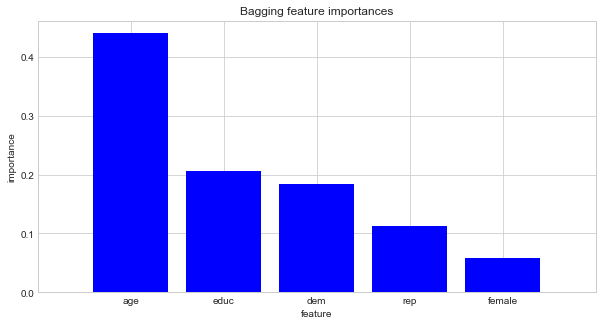

In [98]:
plt.figure(figsize = (10, 5))
plt.title("Bagging feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(X.shape[1]), ['age','educ','dem','rep','female'])
plt.xlim([-1, X.shape[1]])
plt.xlabel('feature')
plt.ylabel('importance')
plt.show()

The MSE I got is 405.3. When using the bagging method, the most important feature turns out to be age, followed by education and whether the respondent is democrat.

#### (d) Use the random forest approach to estimate a tree to create a model for predicting biden. Do this for m = 1, m = 2, and m = 3 (the number of variables). What test MSE do you obtain in each case? Obtain variable importance measures and interpret the results. Describe the eect of m, the number of variables considered at each split, on the error rate obtained.

In [82]:
from sklearn.ensemble import RandomForestRegressor

biden_tree_rf1 = RandomForestRegressor(n_estimators=100, max_features=1, bootstrap=True,
                                  oob_score=True, random_state=25)
biden_tree_rf1.fit(X, y)

biden_tree_rf1.score(X, y)
y_pred_rf1 = biden_tree_rf1.oob_prediction_
MSE_rf1 = mean_squared_error(y, y_pred_rf1)
print('MSE=', MSE_rf1)


MSE= 534.3579848143758


In [83]:
biden_tree_rf2 = RandomForestRegressor(n_estimators=100, max_features=2, bootstrap=True,
                                  oob_score=True, random_state=25)
biden_tree_rf2.fit(X, y)

biden_tree_rf2.score(X, y)
y_pred_rf2 = biden_tree_rf2.oob_prediction_
MSE_rf2 = mean_squared_error(y, y_pred_rf2)
print('MSE=', MSE_rf2)


MSE= 540.4003453755143


In [102]:
biden_tree_rf3 = RandomForestRegressor(n_estimators=100, max_features=3, bootstrap=True,
                                  oob_score=True, random_state=25)
biden_tree_rf3.fit(X, y)

biden_tree_rf3.score(X, y)
y_pred_rf3 = biden_tree_rf3.oob_prediction_
MSE_rf3 = mean_squared_error(y, y_pred_rf3)
print('MSE=', MSE_rf3)

MSE= 533.8640940413409


Feature ranking:
1 .  age :  0.5126983580141853
2 .  dem :  0.18192676787077108
3 .  educ :  0.15195846143095348
4 .  rep :  0.1306897372089607
5 .  female :  0.022726675475129725


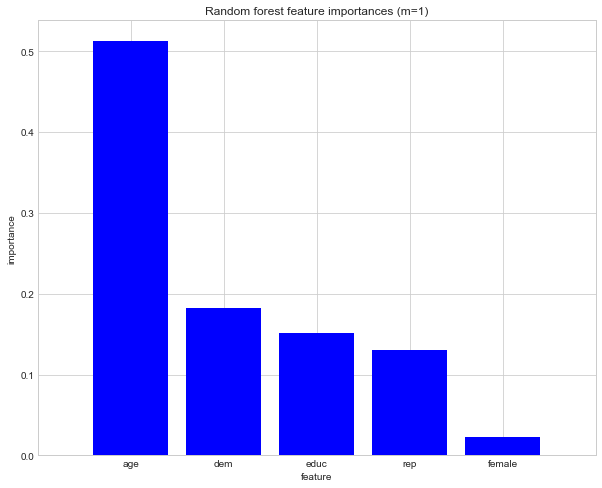

In [103]:
importances = biden_tree_rf1.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_tree_rf1.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

features = ['female', 'age', 'dem', 'rep', 'educ']

for f in range(X.shape[1]):
    print(str(f+1), ". ", features[indices[f]], ": ",str(importances[indices[f]]))

plt.figure()
plt.title("Random forest feature importances (m=1)")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(X.shape[1]), ['age','dem','educ','rep','female'])
plt.xlim([-1, X.shape[1]])
plt.xlabel('feature')
plt.ylabel('importance')
plt.show()

Feature ranking:
1 .  age :  0.5160433816835629
2 .  dem :  0.17152837921183597
3 .  educ :  0.15021343255505268
4 .  rep :  0.14056993426661202
5 .  female :  0.021644872282936475


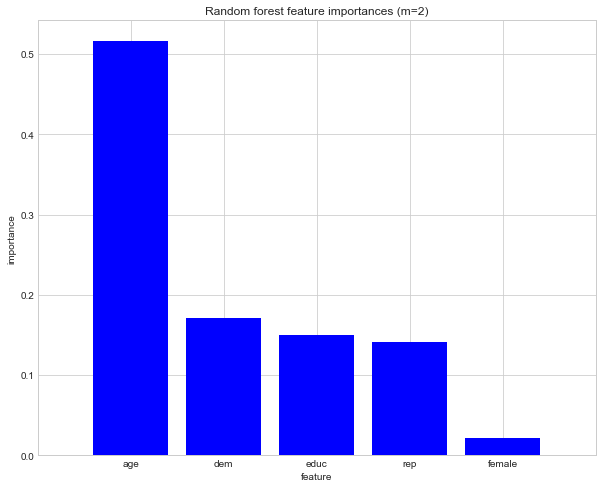

In [104]:
importances = biden_tree_rf2.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_tree_rf2.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

features = ['female', 'age', 'dem', 'rep', 'educ']

for f in range(X.shape[1]):
    print(str(f+1), ". ", features[indices[f]], ": ",str(importances[indices[f]]))

plt.figure()
plt.title("Random forest feature importances (m=2)")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(X.shape[1]), ['age','dem','educ','rep','female'])
plt.xlim([-1, X.shape[1]])
plt.xlabel('feature')
plt.ylabel('importance')
plt.show()

Feature ranking:
1 .  age :  0.49272032676347005
2 .  dem :  0.18867036521350894
3 .  educ :  0.1626167110360209
4 .  rep :  0.12777724414191055
5 .  female :  0.02821535284508939


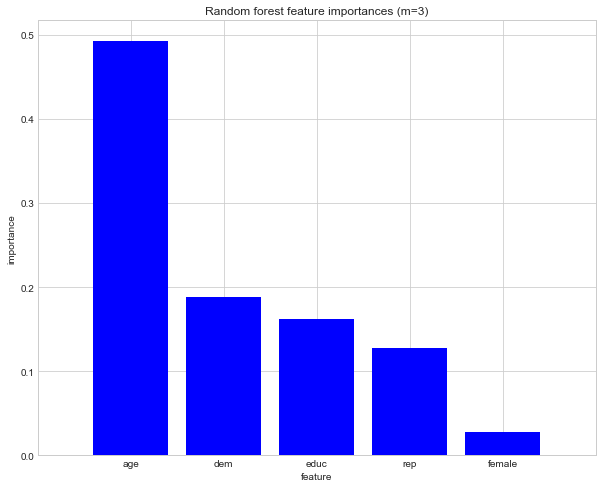

In [105]:
importances = biden_tree_rf3.feature_importances_
std = np.std([tree.feature_importances_ for tree in biden_tree_rf3.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

features = ['female', 'age', 'dem', 'rep', 'educ']

for f in range(X.shape[1]):
    print(str(f+1), ". ", features[indices[f]], ": ",str(importances[indices[f]]))

plt.figure()
plt.title("Random forest feature importances (m=3)")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(X.shape[1]), ['age','dem','educ','rep','female'])
plt.xlim([-1, X.shape[1]])
plt.xlabel('feature')
plt.ylabel('importance')
plt.show()

Similar to bagging, the random forest method also treats age as the most important feature, and dem and education as the following two, though the order was slightly different. The MSEs obtained are larger than bagging or using a single tree. 